In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## 1. Define S(Q,t) function

In [2]:
def f_sqt_chain(Q, t, N=100, b=1.0, D=1.0, tau_R=1.0, p_max=10):
    """
    Compute the scattering function S(Q, t) for a Gaussian polymer chain.

    Parameters:
        Q (numpy.ndarray): Scattering vector magnitude (2D array)
        t (numpy.ndarray): Time (2D array)
        N (int): Number of beads in the polymer chain (default 100)
        b (float): Bond length (default 1.0)
        D (float): Diffusion coefficient (default 1.0)
        tau_R (float): Relaxation time (default 1.0)
        p_max (int): Number of terms in the summation for Phi_nm^1 (default 50)

    Returns:
        numpy.ndarray: Value of S(Q, t) (2D array)
    """

    # Indices for polymer beads
    n_values, m_values = np.meshgrid(np.arange(N), np.arange(N))
    abs_nm = np.abs(n_values - m_values)

    # Compute Phi_nm(t) components
    Phi_D = 6 * D * t  # Center-of-mass diffusion
    Phi_nm_0 = abs_nm * b**2  # Gaussian chain contribution

    # Compute Phi_nm^1 (dynamic part)
    Phi_nm_1 = ((4 * N * b**2 / np.pi**2) * 
                np.sum([(1 / p**2) * np.einsum('kl,ij->ijkl', 
                                               np.cos(p * np.pi * n_values / N) * np.cos(p * np.pi * m_values / N), 
                                               (1 - np.exp(-t * p**2 / tau_R))) 
                        for p in range(1, p_max+1)], # sum over p
                       axis=0))
    
    # Total Phi_nm
    Phi_nm = Phi_D[:, :, None, None] + Phi_nm_0[None, None, :, :] + Phi_nm_1
    
    # Compute S(Q, t) using einsum
    Q_squared = Q**2  # Shape [i, j]
    Q_squared_expanded = Q_squared[:, :, None, None]  # Shape [i, j, 1, 1]
    sqt = (1 / N) * np.einsum('ijkl,ijkl->ij', np.exp(- (1/6) * Q_squared_expanded * Phi_nm), np.ones_like(Phi_nm))


    return sqt


## 2. Test visualize S(Q,t)

In [3]:
n_Q = 100
n_t = 100

t = (np.arange(n_t))/n_t*10
b = 0.5
N = 20
D = 0.1
Rg = np.sqrt(N*b**2/6)

QRg = (np.arange(n_Q))/n_Q*6
Q = QRg/Rg

Q_grid, t_grid = np.meshgrid(QRg, t)

sqt = f_sqt_chain(Q_grid, t_grid, N=N, b=b, D=D, tau_R=1.0, p_max=100)
sq0 = sqt[0, :]

/tmp/ipykernel_3633097/779108266.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([np.min(QRg), np.max(QRg)])
/tmp/ipykernel_3633097/779108266.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([np.min(t), np.max(t)])


(1.0, 9.9)

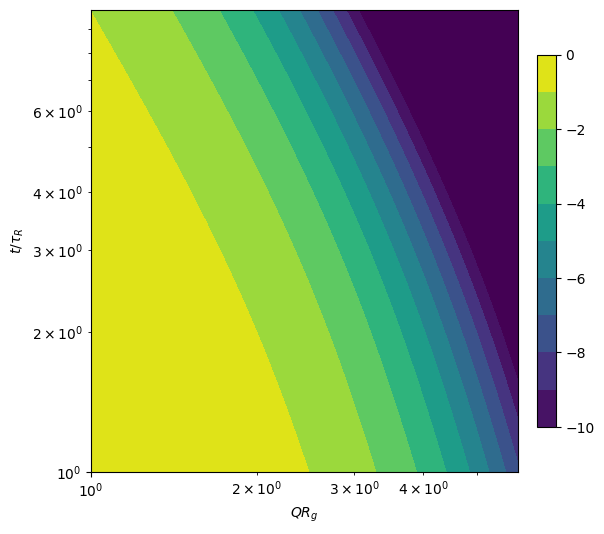

In [4]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
c = ax.pcolormesh(Q_grid, t_grid, np.log(sqt/sq0), cmap='viridis', vmax=0, vmin=-10) 
c = ax.contourf(Q_grid, t_grid, np.log(sqt/sq0), levels=np.linspace(-10, 0, 11), cmap='viridis', vmax=0, vmin=-10)
fig.colorbar(c, ax=ax, fraction=0.04, pad=0.04)
ax.set_xlim([1,6])
ax.set_ylim([1,10])
ax.set_xlabel(r'$QR_g$')
ax.set_ylabel(r'$t/\tau_R$')
ax.set_xscale('log')
ax.set_yscale('log')

# ax.set_aspect('equal')

ax.set_xlim([np.min(QRg), np.max(QRg)])
ax.set_ylim([np.min(t), np.max(t)])




Text(0, 0.5, '$S(QR_g=1,t)$')

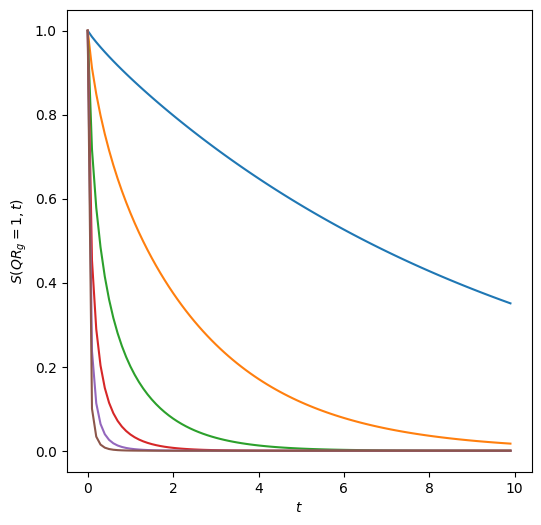

In [5]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for q in [1,2,3,4,5,6]:
    ax.plot(t, (sqt/sq0)[:, np.argmin(np.abs(QRg - q))], label=r'$Q=0$')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$S(QR_g=1,t)$')

Text(0, 0.5, '$S(Q,t=0)$')

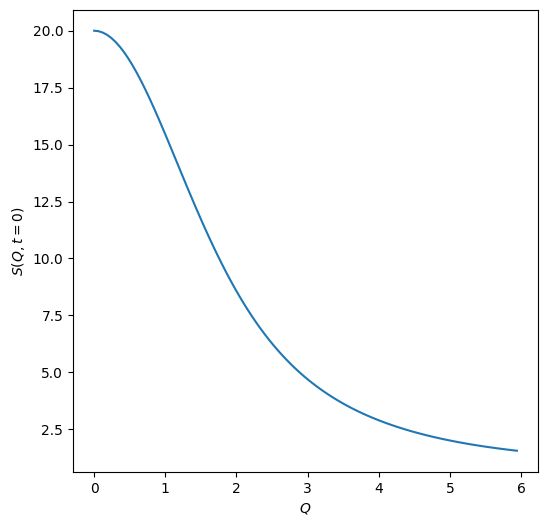

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(QRg, sq0)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$Q$')
ax.set_ylabel(r'$S(Q,t=0)$')